In [1]:
#%% Import Moduels

## System Tools
from _Public import *

## Output Folder
OutputFolder = 'Micro_data/results/AbReturnCyclicality/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
## Self-written Modules
import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR

# Construct the sample

## Load in the data

In [21]:
DataFolder          =   "Micro_data\\datasets\\SDC\\"
SDC_AccAbRet        =   pd.read_pickle(DataFolder+"SDC_AccAbRet.p")
SDC_IssuanceInfo    =   pd.read_pickle(DataFolder+"SDC_IssuanceInfo.p") 

In [23]:
VarList_AbRet = ['FF5_F_AccAbRet', 'FF5_I_AccAbRet', 'FF5_L_AccAbRet']

temp = SDC_AccAbRet.loc[:, VarList_AbRet]
temp[VarList_AbRet] = temp[VarList_AbRet]*100
temp = temp.rename(columns={x: x.replace('FF5_', '') for x in VarList_AbRet}).reset_index()

In [24]:
Sample = SDC_IssuanceInfo.merge(temp, how='left', left_on='IssueID', right_on='IssueID', indicator=True)

In [25]:
Sample['_merge'].value_counts()

_merge
both          7707
left_only      223
right_only       0
Name: count, dtype: int64

In [26]:
Sample.drop('_merge', axis=1, inplace=True)

## Clean the data

In [27]:
# Measure the price drop differently for firms with different shelf-issuance type 
TempInd = Sample['ShelfIssueFlag']==1

Sample['EventDate'] = Sample['FilingDate']
Sample.loc[TempInd, 'EventDate'] = Sample.loc[TempInd, 'IssueDate']

Sample['AccAbRet'] = Sample['F_AccAbRet']
Sample.loc[TempInd, 'AccAbRet'] = Sample.loc[TempInd, 'I_AccAbRet']

Sample['EventDate_Quarter'] = Sample['FilingDate_Quarter']
Sample.loc[TempInd, 'EventDate_Quarter'] = Sample.loc[TempInd, 'IssueDate_Quarter']

In [28]:
# Different measures of issuance 
Sample['LogProceeds'] = np.log(Sample['ProceedsAmount'])
Sample['Proceed_Asset'] = Sample['ProceedsAmount'] / Sample['TotalAsset_BeforeOffering']
Sample['Proceed_Equity'] = Sample['ProceedsAmount'] / Sample['TotalEquity']
Sample['Log_Asset'] = np.log(Sample['TotalAsset_BeforeOffering'])
Sample['Leverage'] = Sample['TotalDebt'] / Sample['TotalAsset_BeforeOffering']
Sample['ExtraShare'] = Sample['OfferedTotalShares']/Sample['TotalShares_BeforeOffering']

b:\Dropbox\Research Projects\02_HeteFirm_AsymetricInformation\Data\venv_py13\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
# Add the recession indicator
NBER_recessions = [
    (datetime.date(1980, 1, 1), datetime.date(1980, 7, 1)),
    (datetime.date(1981, 7, 1), datetime.date(1982, 11, 1)),
    (datetime.date(1990, 7, 1), datetime.date(1991, 3, 1)),
    (datetime.date(2001, 3, 1), datetime.date(2001, 11, 1)),
    (datetime.date(2007, 12, 1), datetime.date(2009, 6, 1)),
    # Add more recession periods as needed
]

def is_during_nber_recession(date):
    """
    Check if a given date falls within any NBER recession period.
'
    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is during an NBER recession, False otherwise.
    """
    for start, end in NBER_recessions:
        if start <= date <= end:
            return True
    return False

Sample['EventDate_RecFlag'] = Sample['EventDate'].apply(lambda x: is_during_nber_recession(x)*1 if pd.isna(x)==False else np.nan)

## Clean the Sample

### Clean by date and missing values

In [30]:
TempInd_Date = (Sample['EventDate_Quarter'] > datetime.date(1985, 1, 1) ) & (Sample['EventDate_Quarter'] < datetime.date(2019, 1, 1))
TempInd_NaN = np.isfinite(Sample[['Proceed_Asset', 'AccAbRet', 'LogProceeds', 'ExtraShare']]).all(axis=1)

In [31]:
Sample = Sample.loc[TempInd_Date & TempInd_NaN, :]

### Clean by outliers

In [32]:
VarList = ['Proceed_Asset', 'Proceed_Equity', 'ExtraShare', 'AccAbRet']
PctList = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]

In [34]:
DescStat = Sample[VarList].describe(percentiles=PctList)
DescStat 

,Proceed_Asset,Proceed_Equity,ExtraShare,AccAbRet
count,6140.000000,4764.000000,6140.000000,6027.0
mean,0.615095,0.579218,10.377914,-2.776659
std,2.896428,5.367772,731.951930,8.07391
min,0.000021,-39.675000,0.000000,-73.96366
0.1%,0.003631,-17.489207,0.001160,-53.681448
0.5%,0.008907,-4.363545,0.006199,-37.897758
1%,0.014320,-1.947343,0.012336,-28.991755
5%,0.037424,0.052873,0.037838,-14.036717
10%,0.055212,0.106435,0.057774,-10.330709
25%,0.118940,0.228332,0.094380,-6.08927


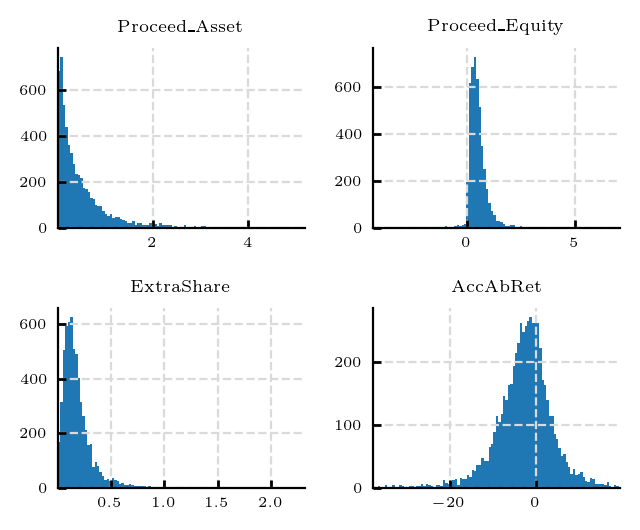

In [35]:
Fig = MyGR.Setup_Fig(FigSize=(1/5 * 2, 1/6 * 2))
for (ii, vv) in enumerate(VarList):
    ax = Fig.add_subplot(2,2,ii+1)
    tempind = (Sample[vv]>DescStat.loc['0.5%', vv]) & (Sample[vv]<DescStat.loc['99.5%', vv])
    Sample.loc[tempind, vv].hist(ax=ax, bins=100)
    ax.set_title(vv, fontsize=6)
    ax.set_xlim(DescStat.loc['0.5%', vv], DescStat.loc['99.5%', vv])
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    MyGR.Setup_Ax(ax)

plt.tight_layout()

In [36]:
Flag_Start = True
for vv in VarList:
    if Flag_Start:
        Flag_Start = False
        TempInd_Outliner = (Sample[vv]<DescStat.loc['0.5%', vv]) | (Sample[vv]>DescStat.loc['99.5%', vv])
    else:
        TempInd_Outliner = TempInd_Outliner | (Sample[vv]<DescStat.loc['0.5%', vv]) | (Sample[vv]>DescStat.loc['99.5%', vv])


In [37]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')

In [38]:
Sample = Sample.loc[tempind, :]

# Unconditional business cycle property

## Time-series plot 

In [39]:
def TempFun_WM(DS,VarList,WeightVar):
    Temp_Num        =   DS[VarList].multiply(DS[WeightVar],axis=0).sum(axis=0)
    Temp_DeNum      =   ( ~pd.isna(DS[VarList]) ).multiply(DS[WeightVar],axis=0).sum(axis=0)
    WM              =   Temp_Num.divide(Temp_DeNum,axis=0)
    WM.name         =   'WMean'
    
    return WM



In [40]:
DataForPlot = pd.concat([Sample.groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index().rename('AccAbRet_Avg'), \
                         Sample.groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ExtraShare', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg')], \
                        axis=1).sort_index()

In [43]:
# Export the aggregate data 
temp = pd.read_pickle('Macro_data/temp/AggDS_Dict_AggPQ.p')

temp['Level'][['GDP', 'PCE', 'PDI', 'PDI_NonRes']].to_csv(OutputFolder+'GFC_CaseStudy_Data_Agg.csv')

In [45]:
# Add the aggregate price and quantity data
temp = pd.read_pickle('Macro_data/temp/AggDS_Dict_AggPQ.p')

DataForPlot = DataForPlot.merge(temp['Detrend'][['Growth_GDP', 'GDP']], left_index=True, right_index=True, how='left')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


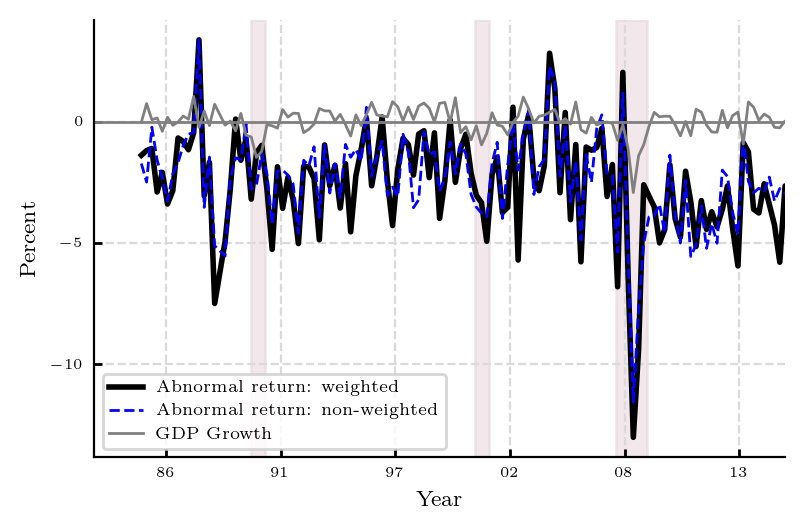

In [47]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg'], ax=ax, Label="Abnormal return: non-weighted")
MyGR.Line(Color="Gray", Style="solid", Width=1).Plot(DataForPlot.index, DataForPlot['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


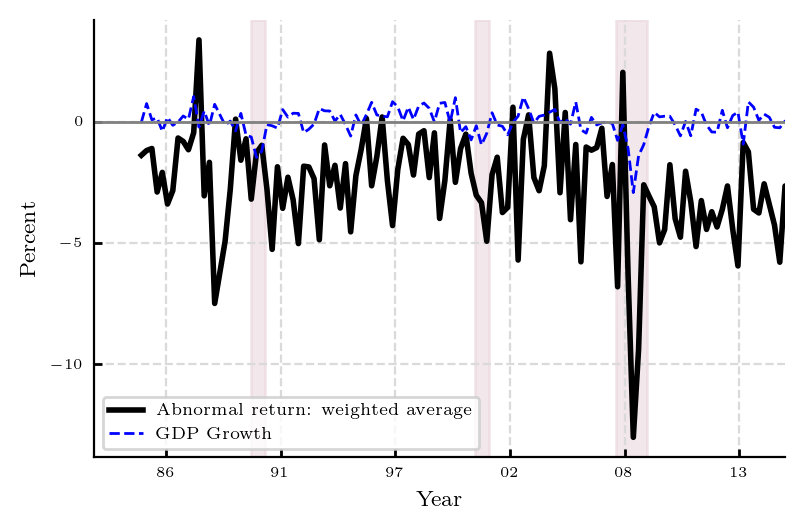

In [48]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted average")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle_OnlyWAvg.eps', format='eps', dpi=1000)

In [49]:
non_nan_index = DataForPlot.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1983,1,1)) & (non_nan_index<=datetime.datetime(2018,12,31))] 

DataForPlot.loc[TempIndex, :].mean()

AccAbRet_Avg    -2.685716
AccAbRet_WAvg   -2.906365
Growth_GDP       0.011787
GDP              2.335782
dtype: Float64

In [50]:
DataForPlot.loc[TempIndex, :].describe()

,AccAbRet_Avg,AccAbRet_WAvg,Growth_GDP,GDP
count,134.0,134.000000,134.000000,134.000000
mean,-2.685716,-2.906365,0.011787,2.335782
std,2.162304,2.512757,0.543980,4.416369
min,-11.571209,-13.034552,-2.932082,-5.609858
25%,-3.771724,-4.254367,-0.200937,-1.199903
50%,-2.344154,-2.652697,0.024773,2.308489
75%,-1.397499,-1.186712,0.341468,6.446219
max,3.371141,3.371141,1.033272,9.933585


In [51]:
DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].autocorr()

np.float64(0.38365389845266124)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


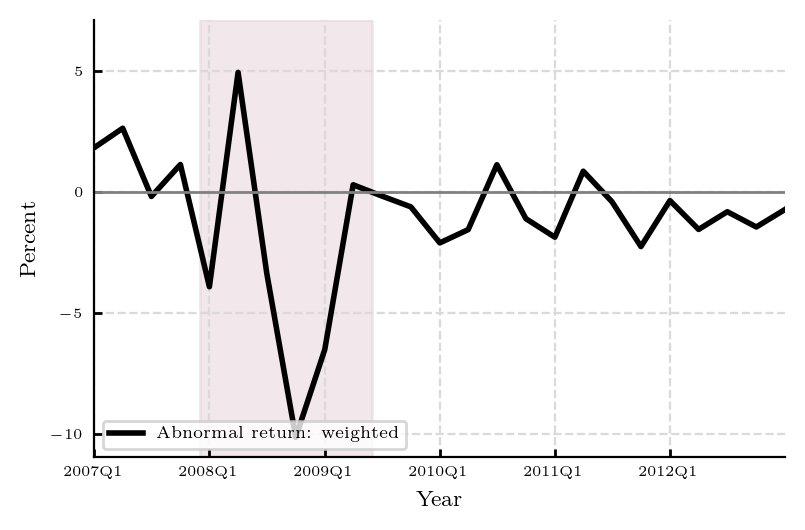

In [52]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'] - DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].mean(), ax=ax, Label="Abnormal return: weighted")

ax.set_xlim([datetime.date(2007,1,1),datetime.date(2012,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=7)

def quarter_format(x, pos):
    dt = mdates.num2date(x)  # Convert to datetime
    quarter = (dt.month - 1) // 3 + 1
    return f"{dt.year}Q{quarter}"
ax.set_xticks([datetime.datetime(yy,1,1) for yy in range(2007,2013, 1)])
ax.xaxis.set_major_formatter(FuncFormatter(quarter_format))
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'GFC_CaseStudy_Data_AccAbRet.eps', format='eps', dpi=1000)

In [53]:
(DataForPlot['AccAbRet_WAvg'] - DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].mean()).to_excel(OutputFolder+'GFC_CaseStudy_Data_AccAbRet.xlsx')

In [54]:
temp = non_nan_index[(non_nan_index>=datetime.datetime(2007,1,1)) & (non_nan_index<=datetime.datetime(2010,12,31))] 
DataForPlot.loc[temp, 'AccAbRet_WAvg'] - DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].mean()

EventDate_Quarter
2007-01-01     1.830753
2007-04-01     2.629723
2007-07-01    -0.185954
2007-10-01     1.132895
2008-01-01    -3.914015
2008-04-01     4.936143
2008-07-01    -3.356012
2008-10-01   -10.128186
2009-01-01    -6.505396
2009-04-01     0.295606
2009-07-01    -0.167828
2009-10-01    -0.615285
2010-01-01    -2.102487
2010-04-01    -1.554223
2010-07-01     1.123700
2010-10-01    -1.103094
Name: AccAbRet_WAvg, dtype: float64

## Correlation with GDP growth

In [59]:
non_nan_index = DataForPlot.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1985,1,1)) & (non_nan_index<=datetime.datetime(2015,12,31))] 

TempVarList = ['AccAbRet_Avg', 'AccAbRet_WAvg']

TempTab = pd.concat([pd.Series(stats.pearsonr(DataForPlot.loc[TempIndex, vv], DataForPlot.loc[TempIndex, 'Growth_GDP']), index=['Corr', 'p-value']) for vv in TempVarList], axis=1, keys=TempVarList)

TempTab.to_latex(OutputFolder+'Corr_w_GDPGrowth.tex', float_format="%.3g", escape=True)

TempTab 

,AccAbRet_Avg,AccAbRet_WAvg
Corr,0.386025,0.338094
p-value,0.000011,0.000140


In [60]:
DataForPlot.loc[TempIndex, :].std()

AccAbRet_Avg      1.92119
AccAbRet_WAvg    2.215267
Growth_GDP       0.564669
GDP              3.952681
dtype: Float64

## Recession vs. Non-Recession

In [61]:
TempIndex = (Sample['EventDate']>=datetime.date(1985,1,1)) & (Sample['EventDate']<=datetime.date(2015,12,31))
TempTab = Sample.loc[TempIndex, :].groupby('EventDate_RecFlag')['AccAbRet'].describe()

TempTab.to_latex(OutputFolder+'AccAbRet_RecessionVsNonRecession.tex', float_format="%.3g", escape=True)

TempTab 

,count,mean,std,min,25%,50%,75%,max
EventDate_RecFlag,,,,,,,,
0.0,2604.0,-2.324729,6.669544,-36.803431,-5.777104,-1.862619,1.384803,19.141529
1.0,156.0,-4.138456,7.711475,-31.153216,-8.112151,-3.726546,0.200846,17.472954


In [62]:
# T-Test of the Abnormal Returns in recessions and non-recessions
group1 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==1), 'AccAbRet']
group2 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==0), 'AccAbRet']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(group1.dropna(), group2.dropna())
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.2683734661841775, P-value: 0.0010949520567670764
